In [ ]:
#Decent Efficnet model in train and validation

#resize 338x338 #NOTE this is not the expected size
#batch size 16
#BCEWithLogitsLoss

#Adam
#lr=0.001

In [2]:
#import packages
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision.transforms.functional as F
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import pathlib
from torch.utils.data import Dataset

import numpy as np
from sklearn.model_selection import train_test_split

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch
import torchvision
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

In [4]:
#good practice to provide class labels as integer arrays

CLASSES = ["BLD", "No BLD"]
class_mapping = {label: idx for idx, label in
                 enumerate(np.unique([CLASSES]))}


In [5]:
#dictonary to modify transformations
config = dict(
    rot=90,
    noise=0.05
)

In [76]:
#make sure image input size matches expected size for the spcific models

train_transform = transforms.Compose(
    #384x384 for efficientnet
    #224x225 for ResNEt and MobileNEt
    #256x256 for Swin
    [transforms.Resize([338,338]), #converts image to the pre-trained model dimension expectations
     #transforms.RandomRotation(degrees=config["rot"]),
     #transforms.RandomVerticalFlip(p=0.5),
     #transforms.RandomHorizontalFlip(p=0.5),
     transforms.Grayscale(3),
     transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),#this is a standard RGB mean and std
    ])

#validation preprocessing
val_transform = transforms.Compose(
    [transforms.Resize([338,338]), #converts image to the pre-trained model dimension expectations
     transforms.Grayscale(3),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),#this is a standard RGB mean and std
     ])
     

In [77]:
#import data
#images in directories converted to tensor format and classes obtained from direcory names

train_dataset = torchvision.datasets.ImageFolder(root='/project/90daydata/nematode_ml/BLD/NematodeDataset/train', transform=train_transform)
#test_dataset = torchvision.datasets.ImageFolder(root='/project/90daydata/nematode_ml/BLD/NematodeDataset/test', transform=val_transform)
val_dataset = torchvision.datasets.ImageFolder(root='/project/90daydata/nematode_ml/BLD/NematodeDataset/val', transform=val_transform)

In [78]:
# Access the transformed image
image, label = train_dataset[0]
# Check the size of the transformed image
print(image.shape) #retuns [channel, height, width]. 3 indicates color. During training an additional element is added, batch_size


torch.Size([3, 338, 338])


In [9]:
train_dataset.class_to_idx

{'BLD': 0, 'No_BLD': 1}

In [131]:
print(f'Number of images in training dataset: {len(train_dataset)}')
#print(f'Number of images in testing dataset: {len(test_dataset)}')
print(f'Number of images in validation dataset: {len(val_dataset)}')

Number of images in training dataset: 80
Number of images in validation dataset: 26


In [17]:
print(train_dataset.classes)

['BLD', 'No_BLD']


In [79]:
#Bing
#how to print example of each image class from dataset pytorch
#loop through and get one image per class

# Create a dictionary to store one example per class
class_examples = {}

# Iterate through the dataset to find one example per class
#unpack img and label pair from train_dataset
for img, label in train_dataset:
    if label not in class_examples:
        #if the label is not in the class_example dict, then store the image
        class_examples[label] = img
        #if the number of classes in class_examples equals the number of classes in the train_dataset, stop
    if len(class_examples) == len(train_dataset.classes):
        break  

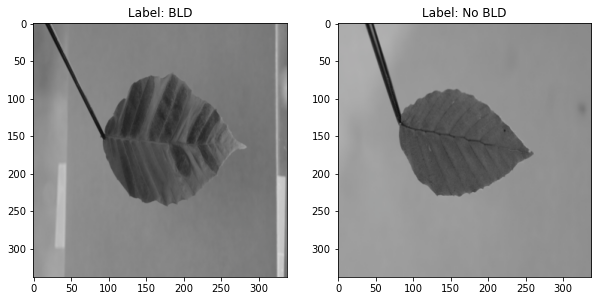

In [81]:
#plot one image from each class in dict 'class_example'
fig = plt.figure(figsize=(10,6))
for label, img in class_examples.items():
    #the dict structure is class label: image
    #print(img)
    #print(label)
    #print(f"Labels batch shape (number): {label.size()}")

    #create subplot shape
    ax = fig.add_subplot(1,2, label+1)
    img = img.numpy().transpose((1, 2, 0)) #changing the channel and dimension order for plotting
    #img = img.numpy().transpose((0, 1, 2))
    #print({img.size})
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    label = label
    ax.imshow(img, cmap="gray")
    #print class title
    ax.set_title(f"Label: {CLASSES[label]}")
plt.show()
   

In [60]:
#a hyperparameter to try changing
#batch_size = 4
batch_size = 16
#batch_size = 32

In [61]:
#dataloader
#output a batch of images and labels, one sample at a time

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
#testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
#                                         shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=True)



In [62]:
#print class for each sample in batch
train_features, train_labels = next(iter(trainloader))
print(train_labels)

tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])


In [ ]:
#Visualize

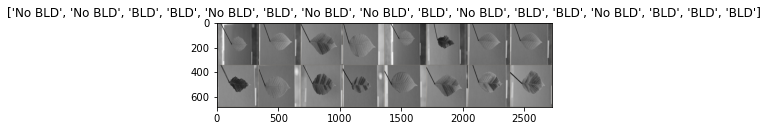

tensor([1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0])


In [64]:
#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[CLASSES[x] for x in classes])
print(classes)

Feature batch shape: torch.Size([16, 3, 338, 338])
Labels batch shape (number): torch.Size([16])


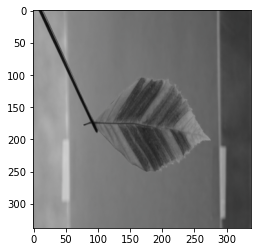

Label: BLD


In [63]:
# Display image and label.
#to pull out a single image and label, first put in individual variables
#https://stackoverflow.com/questions/61480762/python-matplotlib-invalid-shape-for-image-data

train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape (number): {train_labels.size()}")
img = train_features[0].numpy().transpose((1, 2, 0)) #changing the channel and dimension order for plotting
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {CLASSES[label]}")

In [16]:
#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[CLASSES[x] for x in classes])

NameError: name 'trainloader' is not defined

In [21]:
#Import model for training

#EfficientNet V2
weights = EfficientNet_V2_S_Weights.DEFAULT
model_EFV2 = efficientnet_v2_s(weights=weights)
#freeze layers
#for param in model_EFV2.parameters():
#    param.requires_grad = False

#ResNet50
#RN_weights=ResNet50_Weights.DEFAULT
model_RN = torchvision.models.resnet50(pretrained=True)

#Inception V3
#IN_weights=Inception_V3_Weights.DEFAULT
model_IN = torchvision.models.inception_v3(pretrained=True)

#MobileNet
# Small
#MNs_weights=MobileNet_V3_Small_Weights.DEFAULT
model_MNs = torchvision.models.mobilenet_v3_small(pretrained=True)

#Large
#model_MNl = torchvision.models.mobilenet_v3_large(pretrained=True)

#AlexNet
#AN_weights=AlexNet_Weights.DEFAULT
model_AN = torchvision.models.alexnet(pretrained=True)


In [23]:
#first set of code NOT freezing layers

In [22]:
#EfficientNet

#Intitalize model, not freezing layers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_efv2 = model_EFV2
num_ftrs = model_efv2.classifier[1].in_features #print this out to confirm a value

num_classes = 2  # Replace with the number of classes in your dataset
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_efv2.classifier[1] = nn.Linear(in_features=model_efv2.classifier[1].in_features, out_features=num_classes)

#move model to this device
model_efv2 = model_efv2.to(device)

#Loss function

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss() 
criterion = nn.BCEWithLogitsLoss() #recommended for binary classificaion


# Observe that all parameters are being optimized
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001)
optimizer = optim.Adam(model_efv2.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [105]:
#ResNet
#Intitalize model, not freezing layers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_rn = model_RN
num_ftrs = model_rn.fc.in_features #print this out to confirm a value

num_classes = 2  # Replace with the number of classes in your dataset
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_rn.fc = nn.Linear(in_features=model_rn.fc.in_features, out_features=num_classes)

model_rs = model_rs.to(device) #move model to this device



#Loss function

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss() 
criterion = nn.BCEWithLogitsLoss() #recommended for binary classificaion


# Observe that all parameters are being optimized
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001)
optimizer = optim.Adam(model_rs.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [106]:
#Inception V3
#Intitalize model, not freezing layers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_in = model_IN
num_ftrs = model_in.fc.in_features #print this out to confirm a value

num_classes = 2  # Replace with the number of classes in your dataset
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_in.fc = nn.Linear(in_features=model_in.fc.in_features, out_features=num_classes)

model_in = model_in.to(device) #move model to this device


#Loss function

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss() 
criterion = nn.BCEWithLogitsLoss() #recommended for binary classificaion


# Observe that all parameters are being optimized
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001)
optimizer = optim.Adam(model_in.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [107]:
#MobileNet small

#Intitalize model, not freezing layers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_mns = model_MNs
num_ftrs = model_mns.classifier[0].in_features #print this out to confirm a value

num_classes = 2  # Replace with the number of classes in your dataset
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_mns.fc = nn.Linear(num_ftrs, num_classes)

#move model to this device
model_mns = model_mns.to(device)



#Loss function

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss() 
criterion = nn.BCEWithLogitsLoss() #recommended for binary classificaion


# Observe that all parameters are being optimized
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001)
optimizer = optim.Adam(model_mns.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


#Loss function

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss() 
criterion = nn.BCEWithLogitsLoss() #recommended for binary classificaion


# Observe that all parameters are being optimized
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001)
optimizer = optim.Adam(model_mns.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [108]:
#AlexNet

#Intitalize model, not freezing layers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_an = model_AN
num_ftrs = model_an.classifier[6].in_features #print this out to confirm a value

num_classes = 2  # Replace with the number of classes in your dataset
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_an.classifier[6] = nn.Linear(num_ftrs, num_classes)

#move model to this device
#model_an = model_an.to(device)


#Loss function

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss() 
criterion = nn.BCEWithLogitsLoss() #recommended for binary classificaion


# Observe that all parameters are being optimized
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001)
optimizer = optim.Adam(model_an.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [10]:
#Loss function

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss() 
criterion = nn.BCEWithLogitsLoss() #recommended for binary classificaion


# Observe that all parameters are being optimized
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001)
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

NameError: name 'model_ft' is not defined

In [12]:
#Pg. 479 pytorch book
#modified to accomidate BCELoss format expectations in the pred output
#Pg. 473
#If returning 1 probablity from model(x_batch) (using [:,0]), then use BCE function
#If retunring 2 proabability values, use Cross entropy loss function

def train(model, num_epochs, train_d1, valid_d1):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train() #set model to training mode
        for x_batch, y_batch, in train_d1:
            #output of forward pass a tensor with predictions for the batch
            pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
            #print(pred.size(), y_batch.size()) #use this to troubleshoot BCE error. Shapes should match
            loss = criterion(pred, y_batch.float()) 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float() #calculating correct class from first column of pred tensor [:,0]
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_d1.dataset)
        accuracy_hist_train[epoch] /= len(train_d1.dataset)
        
        model.eval() 
        with torch.no_grad():
            for x_batch, y_batch in valid_d1:
                pred = model(x_batch)[:,0] #slicing the first column to make shapes match for BCE loss
                loss = criterion(pred, y_batch.float()) #BCE expects floar
                loss_hist_valid[epoch] += \
                    loss.item() * y_batch.size(0)
                is_correct = \
                    ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_d1.dataset)
            accuracy_hist_valid[epoch] /= len(valid_d1.dataset)

            print(f'Epoch {epoch+1} ' 
                  f'accuracy: {accuracy_hist_train[epoch]:.4f}, '
                  f'val_accuracy: {accuracy_hist_valid[epoch]:.4f}, '
                  f'train_loss: {loss_hist_train[epoch]:.4f}, '
                  f'val_loss: {loss_hist_valid[epoch]:.4f} ')
    return loss_hist_train, loss_hist_valid, \
        accuracy_hist_train, accuracy_hist_valid          

In [13]:
#Train model not frozen
torch.manual_seed(1)
num_epochs = 5
hist = train(model_efv2, num_epochs, trainloader, valloader)

Epoch 1 accuracy: 0.8500, val_accuracy: 0.9615, train_loss: 0.4023, val_loss: 0.0811 
Epoch 2 accuracy: 0.9375, val_accuracy: 0.6154, train_loss: 0.1555, val_loss: 2.2952 
Epoch 3 accuracy: 0.9125, val_accuracy: 0.7308, train_loss: 0.3417, val_loss: 2.8451 
Epoch 4 accuracy: 0.9625, val_accuracy: 0.9615, train_loss: 0.1195, val_loss: 0.0604 
Epoch 5 accuracy: 0.9500, val_accuracy: 0.8077, train_loss: 0.0716, val_loss: 0.3443 


In [ ]:
#Train model not frozen
torch.manual_seed(1)
num_epochs = 5
hist = train(model_efv2, num_epochs, trainloader, valloader)

In [ ]:
#training without data augmentataion in the training set produces a solid training learning curve (accuracy and loss)
#validation still stuck

#ideas
#increase batch size
#decrease learning rate
#try different optimizers
#train longer 
#scaling features
#changing features

#https://stackoverflow.com/questions/52356068/validation-accuracy-constant-in-keras-cnn-for-multiclass-image-classification
#https://www.tutorialspoint.com/fixing-constant-validation-accuracy-in-cnn-model-training#:~:text=In%20this%20post%2C%20we%27ll%20talk%20about%20a%20few,tuning%2C%20regularization%2C%20optimizer%20selection%2C%20initialization%2C%20and%20hyperparameter%20tweaking.
#https://www.researchgate.net/post/How_to_tackle_the_problem_of_constant_val_accuracy_in_CNN_model_training
#https://stackoverflow.com/questions/51933123/how-to-fix-a-constant-validation-accuracy-in-machine-learning
#https://datascience.stackexchange.com/questions/13607/validation-loss-and-accuracy-remain-constant


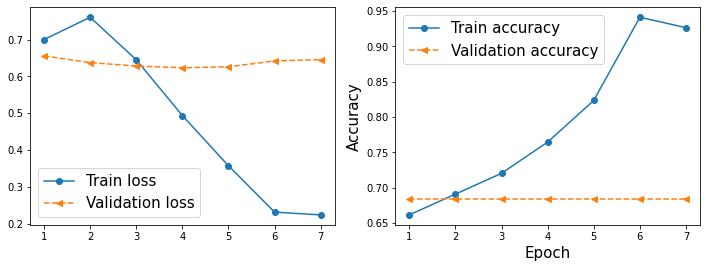

In [29]:
#Plot learning curve
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize = 15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train accuracy')
ax.plot(x_arr, hist[3], '--<',
        label='Validation accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size = 15)
ax.set_ylabel('Accuracy', size=15)
plt.show()




In [30]:
#To freeze all but last layer for training 
#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


model_conv = torchvision.models.efficientnet_v2_s()
for param in model_conv.parameters():
    param.requires_grad = False #freeze all but last layer

num_classes = 2  # Replace with the number of classes in your dataset
# Parameters of newly constructed modules have requires_grad=True by default
model_conv.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=num_classes)

model_conv = model_conv.to(device)

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss() 
criterion = nn.BCEWithLogitsLoss() #recommended for binary classificaion


# Observe that all parameters are being optimized
#optimizer = optim.SGD(model_ft.parameters(), lr=0.001)
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [122]:
#Pg. 494 pytorch book
def train(model, num_epochs, train_d1, valid_d1):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train() #set model to training mode
        for x_batch, y_batch, in train_d1:
            #output of forward pass a tensor with predictions for the batch
            pred = model(x_batch)[:,0] #[:,0] slices the first column of the tensor for all items in the batch
            loss = criterion(pred, y_batch.float()) #swaped in 'criterion'. #.float() ensures data are in correct type
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_d1.dataset)
        accuracy_hist_train[epoch] /= len(train_d1.dataset)
        
        model.eval() 
        with torch.no_grad():
            for x_batch, y_batch in valid_d1:
                pred = model(x_batch)[:,0]
                loss = criterion(pred, y_batch.float()) #swapped in criterion
                loss_hist_valid[epoch] += \
                    loss.item() * y_batch.size(0)
                is_correct = \
                    ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
        loss_hist_valid[epoch] /= len(valid_d1.dataset)
        accuracy_hist_valid[epoch] /= len(valid_d1.dataset)

        print(f'Epoch {epoch+1} ' 
              f'accuracy: {accuracy_hist_train[epoch]:.4f}, '
              f'val_accuracy: {accuracy_hist_valid[epoch]:.4f}, '
              f'train_loss: {loss_hist_train[epoch]:.4f}, '
              f'val_loss: {loss_hist_valid[epoch]:.4f} ')
    return loss_hist_train, loss_hist_valid, \
        accuracy_hist_train, accuracy_hist_valid

In [123]:
#Train model frozen layers
torch.manual_seed(1)
num_epochs = 5
hist = train(model_conv, num_epochs, trainloader, valloader)

NameError: name 'model_conv' is not defined